# 영어로 Word2Vec 만들기

In [1]:
import re
import urllib.request
import zipfile

from lxml import etree
from nltk.tokenize import sent_tokenize, word_tokenize

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml",
    filename="../input/ted_en-20160408.xml",
)

('../input/ted_en-20160408.xml', <http.client.HTTPMessage at 0x1a7600e2790>)

데이터 파일은 xml로 돼있어 전처리가 필요하다. 전처리 작업을 통해 xml 문법을 제거하고 원하는 데이터만 가져오자.

In [3]:
targetXML = open("../input/ted_en-20160408.xml", "r", encoding="UTF8")
target_text = etree.parse(targetXML)
# xml 파일로부터 <content>와 </content> 사이 내용만 가져온다.
parse_text = "\n".join(target_text.xpath("//content/text()"))
parse_text[:20], len(parse_text)

('Here are two reasons', 24222849)

In [4]:
# 정규 표현식의 sub 모듈을 통해 content 중간의 (Audio), (Laughter) 등의 배경음 부분 제거
content_text = re.sub(r"\([^)]*\)", "", parse_text)

In [5]:
# 입력 코퍼스에 대해 NLTK를 사용해 문장 토큰화
sent_text = sent_tokenize(content_text)

In [6]:
normalized_text = []
for string in sent_text:
    # 각 문장에 대해 구두점 제거, 대문자를 소문자로 변환
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

In [7]:
# 각 문장에 대해 NLTK 이용해 단어 토큰화
result = [word_tokenize(sentence) for sentence in normalized_text]
result[:3], len(result)

([['here',
   'are',
   'two',
   'reasons',
   'companies',
   'fail',
   'they',
   'only',
   'do',
   'more',
   'of',
   'the',
   'same',
   'or',
   'they',
   'only',
   'do',
   'what',
   's',
   'new'],
  ['to',
   'me',
   'the',
   'real',
   'real',
   'solution',
   'to',
   'quality',
   'growth',
   'is',
   'figuring',
   'out',
   'the',
   'balance',
   'between',
   'two',
   'activities',
   'exploration',
   'and',
   'exploitation'],
  ['both',
   'are',
   'necessary',
   'but',
   'it',
   'can',
   'be',
   'too',
   'much',
   'of',
   'a',
   'good',
   'thing']],
 273424)

토큰화가 잘 수행되었다. Word2Vec 모델에 데이터를 훈련시키자.

In [8]:
from gensim.models import KeyedVectors, Word2Vec

In [9]:
model = Word2Vec(
    sentences=result,
    # 임베딩 된 벡터 차원
    vector_size=100,
    # 컨텍스트 윈도우 크기
    window=5,
    # 단어 최소 빈도 수 제한 (빈도가 적은 단어는 학습에서 제외)
    min_count=5,
    # 학습을 위한 프로세스 수
    workers=4,
    # 0은 CBOW, 1은 Skip-gram
    sg=0,
)

학습을 진행하였다. Word2Vec은 입력한 단어에 대해 가장 유사한 단어들을 출력하는 model.wv.most_similar를 지원한다.

In [10]:
model_result = model.wv.most_similar("man")
model_result

[('woman', 0.8421722054481506),
 ('guy', 0.8199131488800049),
 ('boy', 0.7690280675888062),
 ('lady', 0.7625884413719177),
 ('girl', 0.756271481513977),
 ('soldier', 0.7358545660972595),
 ('gentleman', 0.7264915108680725),
 ('kid', 0.6969330906867981),
 ('poet', 0.6748313307762146),
 ('david', 0.6612922549247742)]

학습한 모델을 나중에 다시 사용할 수 있게 파일로 저장하고 로드해보자.

In [11]:
model.wv.save_word2vec_format("eng_w2v")  # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v")  # 모델 로드

In [12]:
loaded_model.most_similar("man")

[('woman', 0.8421722054481506),
 ('guy', 0.8199131488800049),
 ('boy', 0.7690280675888062),
 ('lady', 0.7625884413719177),
 ('girl', 0.756271481513977),
 ('soldier', 0.7358545660972595),
 ('gentleman', 0.7264915108680725),
 ('kid', 0.6969330906867981),
 ('poet', 0.6748313307762146),
 ('david', 0.6612922549247742)]

# 한국어 Word2Vec 만들기 (네이버 영화 리뷰)

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from konlpy.tag import Okt
from tqdm import tqdm

In [14]:
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt",
    filename="../input/ratings.txt",
)

('../input/ratings.txt', <http.client.HTTPMessage at 0x1a73bcc2a00>)

In [16]:
train_data = pd.read_table("../input/ratings.txt")
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [17]:
len(train_data)

200000

In [19]:
train_data.isnull().values.any()

True

In [20]:
train_data = train_data.dropna(how="any")
train_data.isnull().values.any()

False

In [21]:
len(train_data)

199992

정규 표현식을 통해 한글이 아닌 경우 제거하자.

In [22]:
train_data["document"] = train_data["document"].str.replace(
    "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True
)

In [23]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


학습 시 사용하지 않을 불용어를 제거하자.

In [24]:
stopwords = [
    "의",
    "가",
    "이",
    "은",
    "들",
    "는",
    "좀",
    "잘",
    "걍",
    "과",
    "도",
    "를",
    "으로",
    "자",
    "에",
    "와",
    "한",
    "하다",
]

In [25]:
okt = Okt()

In [29]:
tokenized_data = []
for sentence in tqdm(train_data["document"]):
    # stem=True로 어간 추출을 해 단어 기본형 유지
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [
        word for word in tokenized_sentence if not word in stopwords
    ]
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [13:50<00:00, 240.91it/s]


리뷰 최대 길이: 72
리뷰 평균 길이: 10.716703668146726


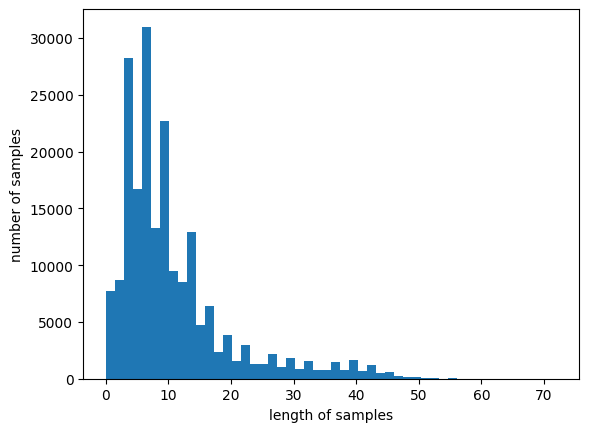

In [30]:
print(
    (
        f"리뷰 최대 길이: {max(len(review) for review in tokenized_data)}\n"
        f"리뷰 평균 길이: {sum(map(len, tokenized_data)) / len(tokenized_data)}"
    )
)
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습한다.

In [31]:
model = Word2Vec(
    sentences=tokenized_data, vector_size=100, window=5, min_count=5, workers=4, sg=0
)

In [32]:
model.wv.vectors.shape

(16477, 100)

16477개의 단어가 있고 각 단어는 100차원으로 구성되어 있다.

In [33]:
model.wv.most_similar("최민식")

[('안성기', 0.8505879640579224),
 ('박중훈', 0.836275577545166),
 ('양동근', 0.8357295989990234),
 ('김명민', 0.8321253657341003),
 ('김수현', 0.831449031829834),
 ('채민서', 0.8249853253364563),
 ('윤제문', 0.8245498538017273),
 ('최민수', 0.8245446681976318),
 ('한석규', 0.8174071907997131),
 ('이정재', 0.8157333731651306)]

In [34]:
model.wv.most_similar("히어로")

[('슬래셔', 0.8806781768798828),
 ('무협', 0.8803909420967102),
 ('호러', 0.8603289127349854),
 ('느와르', 0.8525978326797485),
 ('블록버스터', 0.8237674236297607),
 ('물의', 0.811237633228302),
 ('멜로', 0.8107128143310547),
 ('물', 0.8054773807525635),
 ('무비', 0.8052991628646851),
 ('뱀파이어', 0.7958634495735168)]

# 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding)

In [35]:
import gensim

In [36]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(
    "../model/GoogleNews-vectors-negative300.bin.gz", binary=True
)

In [37]:
word2vec_model.vectors.shape

(3000000, 300)

3백만 개의 단어가 있고 각 단어의 차원은 300이다.

In [38]:
word2vec_model.similarity("this", "is")

0.40797034

In [39]:
word2vec_model.similarity("post", "book")

0.057204384

In [40]:
word2vec_model["book"]

array([ 0.11279297, -0.02612305, -0.04492188,  0.06982422,  0.140625  ,
        0.03039551, -0.04370117,  0.24511719,  0.08740234, -0.05053711,
        0.23144531, -0.07470703,  0.21875   ,  0.03466797, -0.14550781,
        0.05761719,  0.00671387, -0.00701904,  0.13183594, -0.25390625,
        0.14355469, -0.140625  , -0.03564453, -0.21289062, -0.24804688,
        0.04980469, -0.09082031,  0.14453125,  0.05712891, -0.10400391,
       -0.19628906, -0.20507812, -0.27539062,  0.03063965,  0.20117188,
        0.17382812,  0.09130859, -0.10107422,  0.22851562, -0.04077148,
        0.02709961, -0.00106049,  0.02709961,  0.34179688, -0.13183594,
       -0.078125  ,  0.02197266, -0.18847656, -0.17480469, -0.05566406,
       -0.20898438,  0.04858398, -0.07617188, -0.15625   , -0.05419922,
        0.01672363, -0.02722168, -0.11132812, -0.03588867, -0.18359375,
        0.28710938,  0.01757812,  0.02185059, -0.05664062, -0.01251221,
        0.01708984, -0.21777344, -0.06787109,  0.04711914, -0.00